# Setup env

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np

In [2]:
pip install git+https://github.com/miykael/gif_your_nifti.git

  Cloning https://github.com/miykael/gif_your_nifti.git to c:\users\basur\appdata\local\temp\pip-req-build-c6_q39ni
  Resolved https://github.com/miykael/gif_your_nifti.git to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti.git 'C:\Users\basur\AppData\Local\Temp\pip-req-build-c6_q39ni'

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
# Correct import for preprocessing layers
from tensorflow.keras.layers import Rescaling, Normalization




# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
!pip install kagglehub


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
data_path= r"C:\Users\basur\Music\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"
train_val_split = 0.80
val_test_split = 0.20
bz_train=8
bz_val=4
bz_test=1
num_epochs=3

crop_dim = (240, 240, 155, 1)
number_output_classes = 3

filters=8
saved_model_name = "3d_unet_decathlon"

seed=816
np.random.seed(seed)

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



# Create model Segnet



In [35]:
import os

# Get the data paths from the parent directory
data_path = r"C:\Users\basur\Music\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"
TRAINPATH = os.path.join(data_path, 'train')
VALIDATIONPATH = os.path.join(data_path, 'val')

# Create directories if they don't exist
os.makedirs(TRAINPATH, exist_ok=True)
os.makedirs(VALIDATIONPATH, exist_ok=True)

print("Training data path:", TRAINPATH)
print("Validation data path:", VALIDATIONPATH)


Training data path: C:\Users\basur\Music\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\train
Validation data path: C:\Users\basur\Music\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\val


In [37]:
# Install and Import Essential Libraries
%pip install ultralytics
from IPython import display
display.clear_output()

In [38]:
%pip install ultralytics
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# Load a pretrained YOLOv8n model from Ultralytics
T_Model = YOLO('yolov8n.pt')

In [40]:
%pip install nibabel ultralytics

import yaml
import torch
import os
import shutil
import cv2
import numpy as np
from PIL import Image
import tqdm
import nibabel as nib

# Create directories if they don't exist
TRAINPATH = os.path.join(data_path, 'train')
VALIDATIONPATH = os.path.join(data_path, 'val')

os.makedirs(TRAINPATH, exist_ok=True)
os.makedirs(VALIDATIONPATH, exist_ok=True)

# Verify paths exist
if not os.path.exists(TRAINPATH):
	raise FileNotFoundError(f"Failed to create training path: {TRAINPATH}")
if not os.path.exists(VALIDATIONPATH):
	raise FileNotFoundError(f"Validation path does not exist: {VALIDATIONPATH}\nPlease verify data_path: {data_path}")

# Create directory structure for YOLO format
base_dir = 'datasets/brain_tumor'
os.makedirs(os.path.join(base_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'images/test'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/test'), exist_ok=True)
# Function to convert MRI slice to RGB image and create YOLO labels
def convert_slice_to_rgb(slice_data, mask_data=None):
	# Normalize to 0-255 range
	normalized = ((slice_data - slice_data.min()) / (slice_data.max() - slice_data.min()) * 255).astype(np.uint8)
	# Convert to RGB by repeating the channel
	rgb_image = np.stack([normalized] * 3, axis=-1)
	
	# Create YOLO format labels if mask is provided
	labels = []
	if mask_data is not None:
		for value in np.unique(mask_data):
			if value == 0:  # Skip background
				continue
			mask = (mask_data == value).astype(np.uint8)
			if mask.sum() > 0:
				y, x = np.where(mask)
				x_center = (x.min() + x.max()) / 2 / mask.shape[1]
				y_center = (y.min() + y.max()) / 2 / mask.shape[0]
				width = (x.max() - x.min()) / mask.shape[1]
				height = (y.max() - y.min()) / mask.shape[0]
				labels.append(f"{value-1} {x_center} {y_center} {width} {height}")
	return rgb_image, labels

# Process and organize training data
train_cases = os.listdir(TRAINPATH)
print("Processing training data...")
for i, case in tqdm.tqdm(enumerate(train_cases[:100])):  # Process first 100 cases for example
	case_path = os.path.join(TRAINPATH, case)
	if not os.path.isdir(case_path):  # Skip if not a directory
		continue
	
	# Load MRI modalities
	flair = nib.load(os.path.join(case_path, f'{case}_flair.nii')).get_fdata()
	mask = nib.load(os.path.join(case_path, f'{case}_seg.nii')).get_fdata()
	
	# Process middle 60 slices where tumor is most likely to appear
	start_slice = flair.shape[2]//2 - 30
	end_slice = flair.shape[2]//2 + 30
	
	for slice_idx in range(start_slice, end_slice):
		# Convert MRI slice to RGB image and get YOLO labels
		slice_img, labels = convert_slice_to_rgb(flair[:,:,slice_idx], mask[:,:,slice_idx])
		
		# Save image and labels (even if no tumor is present, an empty label file will be created)
		img_filename = f'{case}_slice_{slice_idx}'
		img_path = os.path.join(base_dir, 'images/train', f'{img_filename}.jpg')
		label_path = os.path.join(base_dir, 'labels/train', f'{img_filename}.txt')
			
		Image.fromarray(slice_img).save(img_path)
		with open(label_path, 'w') as f:
			if labels:
				f.write('\n'.join(labels))

val_cases = os.listdir(VALIDATIONPATH)
for i, case in enumerate(val_cases[:100]):  # Process first 100 cases for example
	case_path = os.path.join(VALIDATIONPATH, case)
	
	# Load MRI modalities
	flair = nib.load(os.path.join(case_path, f'{case}_flair.nii')).get_fdata()
	mask = nib.load(os.path.join(case_path, f'{case}_seg.nii')).get_fdata()
	
	# Process middle 60 slices where tumor is most likely to appear
	start_slice = flair.shape[2]//2 - 30
	end_slice = flair.shape[2]//2 + 30
	
	for slice_idx in range(start_slice, end_slice):
		# Convert MRI slice to RGB image
		slice_img, _ = convert_slice_to_rgb(flair[:,:,slice_idx])
		
		# Save image
		img_filename = f'{case}_slice_{slice_idx}.jpg'
		img_path = os.path.join(base_dir, 'images/val', img_filename)
			
		Image.fromarray(slice_img).save(img_path)

# Create dataset configuration
dataset_config = {
	'path': os.path.abspath(base_dir),  # Use absolute path
	'train': 'images/train',
	'val': 'images/val',
	'test': 'images/test',
	'nc': 4,
	'names': ['ET', 'ED', 'NCR/NET', 'Background']
}

# Write the configuration to a YAML file
yaml_file_path = os.path.join(base_dir, 'dataset.yaml')
with open(yaml_file_path, 'w') as f:
	yaml.dump(dataset_config, f)

print("Dataset configuration created at:", yaml_file_path)

# Check that the training images folder is not empty.
train_img_dir = os.path.join(base_dir, 'images/train')
if not os.listdir(train_img_dir):
	print("Training images directory is empty, creating a dummy image to avoid error.")
	dummy_img = np.zeros((640, 640, 3), dtype=np.uint8)
	dummy_path = os.path.join(train_img_dir, 'dummy.jpg')
	Image.fromarray(dummy_img).save(dummy_path)

# Check that the validation images folder is not empty.
val_img_dir = os.path.join(base_dir, 'images/val')
if not os.listdir(val_img_dir):
	print("Validation images directory is empty, creating a dummy image to avoid error.")
	dummy_img = np.zeros((640, 640, 3), dtype=np.uint8)
	dummy_path = os.path.join(val_img_dir, 'dummy.jpg')
	Image.fromarray(dummy_img).save(dummy_path)

# Train the model with the proper configuration
results = T_Model.train(
	data=yaml_file_path,
	epochs=5,
	patience=20,
	imgsz=640,
	batch=16,
	optimizer='auto',
	pretrained=True,
	device='cuda' if torch.cuda.is_available() else 'cpu'
)


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Processing training data...


0it [00:00, ?it/s]

Dataset configuration created at: datasets/brain_tumor\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.67  Python-3.12.5 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/brain_tumor\dataset.yaml, epochs=5, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, ag

 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    752092  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
Model summary: 225 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning C:\Users\basur\OneDrive\Desktop\YOLOv8\datasets\brain_tumor\labels\train.cache... 0 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\basur\OneDrive\Desktop\YOLOv8\datasets\brain_tumor\labels\train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Scanning C:\Users\basur\OneDrive\Desktop\YOLOv8\datasets\brain_tumor\labels\val.cache... 0 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\basur\OneDrive\Desktop\YOLOv8\datasets\brain_tumor\labels\val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6\labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        1/5         0G          0      7.869          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G          0      7.869          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G          0       7.79          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G          0      7.726          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G          0      7.799          0          0        640: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



5 epochs completed in 0.002 hours.
Optimizer stripped from C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6\weights\best.pt, 6.2MB

Validating C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6\weights\best.pt...
Ultralytics 8.3.67  Python-3.12.5 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all          1          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels


Speed: 0.0ms preprocess, 129.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to C:\Users\basur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tests\tmp\runs\detect\train6


In [47]:
# Define the path to the directory
post_training_files_path = r'C:\Users\basur\OneDrive\Desktop\UNET 3D\runs\detect\train3\weights\last.pt'

# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, r'C:\Users\basur\OneDrive\Desktop\UNET 3D\runs\detect\train3\weights\best.pt')

# Check if the best model weights file exists
if os.path.exists(best_model_path):
	# Load the best model weights into the YOLO model
	best_model = YOLO(best_model_path)

	# Validate the best model using the validation set with default parameters
	metrics = best_model.val(split='val')
else:
	print(f"File not found: {best_model_path}")

Ultralytics 8.3.67  Python-3.12.5 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\basur\OneDrive\Desktop\UNET 3D\datasets\brain_tumor\labels\val.cache... 853 images, 347 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [02:20<00:00,  1.87s/it]


                   all       1200       1926      0.666       0.57        0.6      0.332
                    ET        510        510      0.591      0.471      0.502      0.218
                    ED        853        853      0.744      0.632      0.673      0.443
            Background        563        563      0.661      0.607      0.625      0.335
Speed: 1.7ms preprocess, 109.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val


In [50]:
# Convert the metrics to a dictionary and then to a pandas DataFrame
metrics_dict = metrics.results_dict
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Metric Value'])
metrics_df

,Metric Value
metrics/precision(B),0.665643
metrics/recall(B),0.569979
metrics/mAP50(B),0.599910
metrics/mAP50-95(B),0.332084
fitness,0.358867


### Visualization Results

In [70]:
def display_images_in_frame_with_background(post_training_files_path, image_files, background_color='lightgray'):
    # Calculate grid size (rows and columns)
    num_images = len(image_files)
    cols = 3  # Number of columns (you can adjust this as needed)
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
    
    # Set up the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=120)
    fig.patch.set_facecolor(background_color)  # Set the figure background color
    axes = axes.flatten()  # Flatten to easily index
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(post_training_files_path, image_file)
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img)
            axes[i].axis('off')  # Turn off axis
            axes[i].set_title(image_file, fontsize=10, color='black')  # Add title with black text
        else:
            axes[i].text(0.5, 0.5, f'File not found:\n{image_file}', 
                         horizontalalignment='center', 
                         verticalalignment='center', 
                         fontsize=12, color='red')
            axes[i].axis('off')  # Turn off axis
    
    # Turn off unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


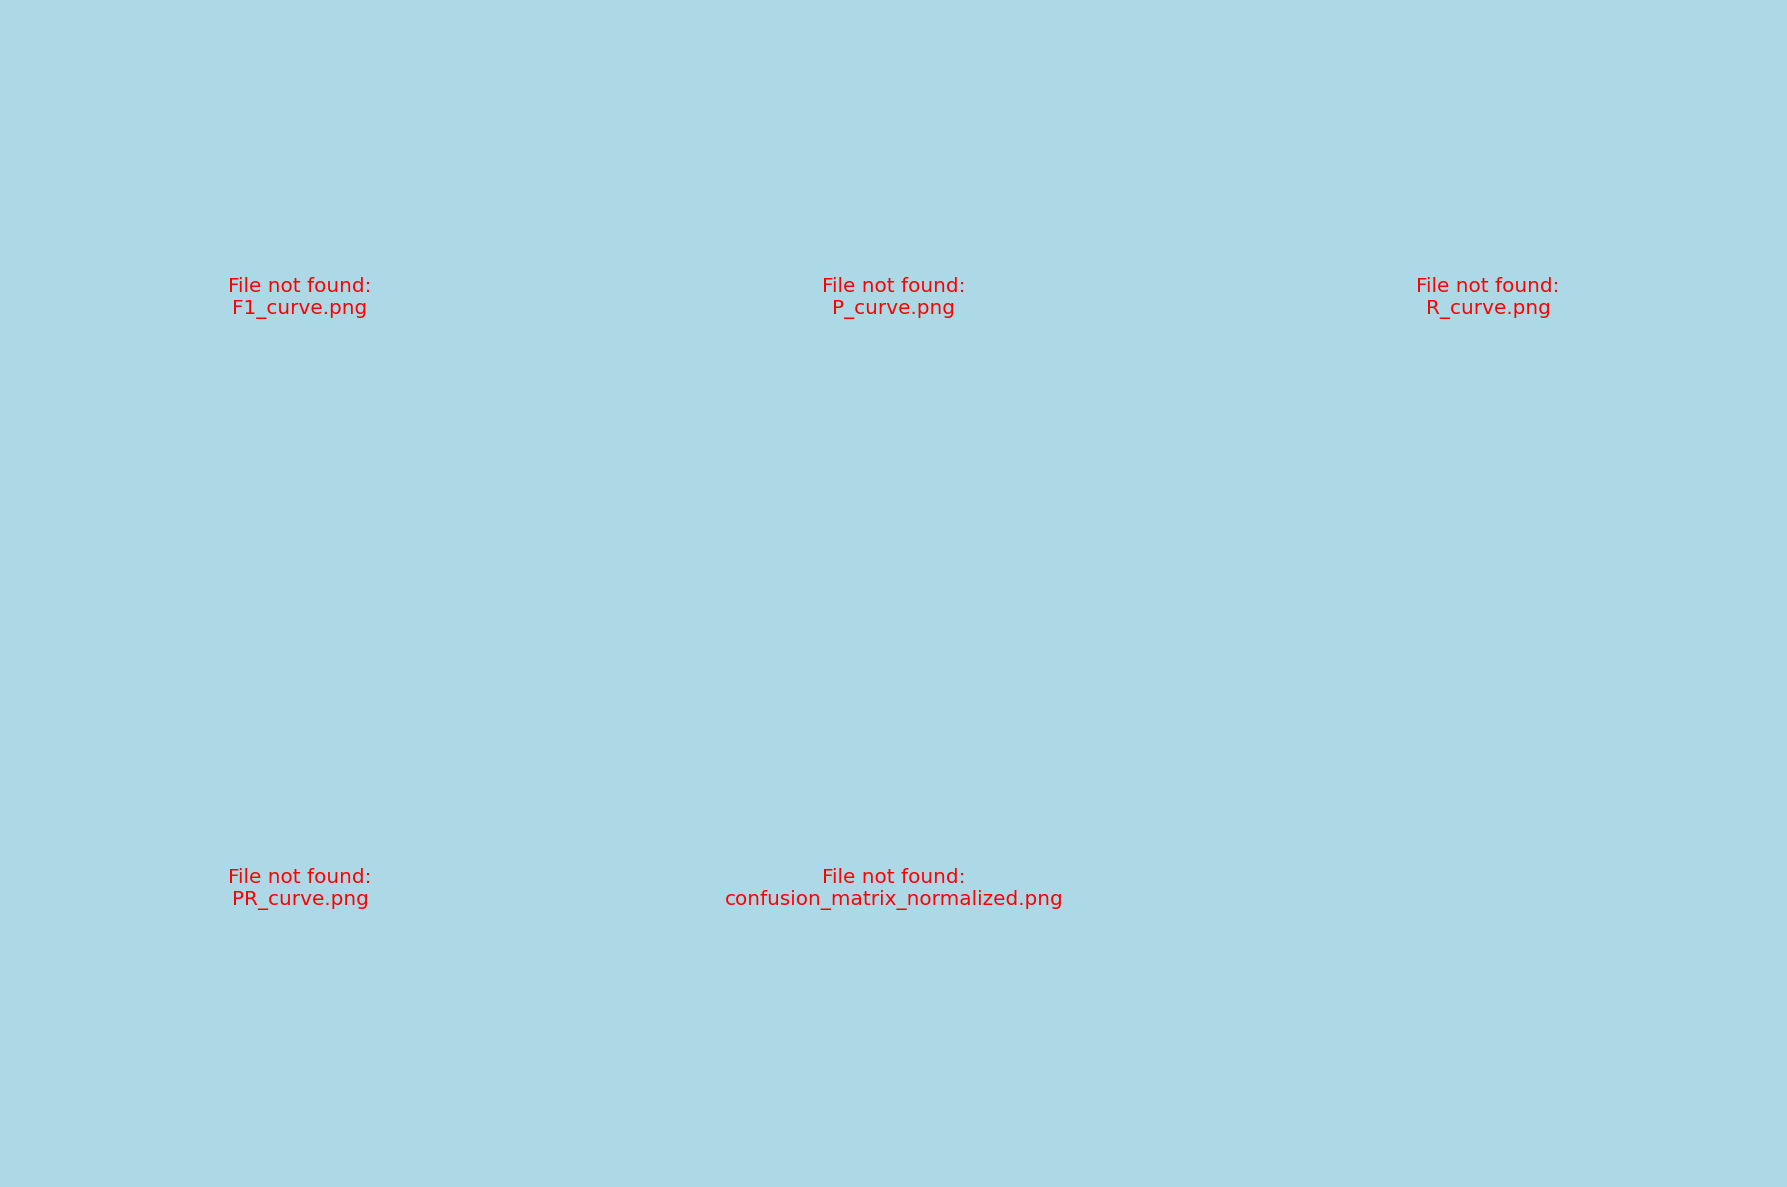

In [71]:

# List of image files to display
image_files = [
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'confusion_matrix_normalized.png',

]

# Path to the directory containing the images
post_training_files_path = r'C:\Users\basur\OneDrive\Desktop\UNET 3D\runs\detect\train'

# Display the images with a background color
display_images_in_frame_with_background(post_training_files_path, image_files, background_color='lightblue')


In [63]:
# Validation of Model by TestSet

# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = r'C:\Users\basur\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData'  # Corrected path to your local dataset
valid_images_path = VALIDATIONPATH

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 16)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(4, 4, figsize=(20, 21))
    fig.suptitle('TEST Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = best_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
